In [1]:
import sys
sys.path.insert(0, '../util')
sys.path.insert(1, '../experiments')

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
from pathlib import Path
import re
import logging
from convert_annotations import read_webanno, webanno_to_iob_df, join_and_resolve, EMPTY_REGEX, VALUE_REGEX, log
import pandas as pd
import transformers, datasets
from transformers import AutoModelForTokenClassification, AutoTokenizer, Trainer, TrainingArguments, pipeline, DataCollatorForTokenClassification, EarlyStoppingCallback, trainer_utils
from huggingface_utils import load_custom_dataset, LabelAligner, compute_metrics, eval_on_test_set
from run_experiment import get_train_args
import hydra
from hydra import compose, initialize

datasets.logging.set_verbosity_error()
transformers.logging.disable_default_handler()
log.setLevel(logging.ERROR)

## Error Analysis

### Load the best model for the span length / granularity settings and the corresponding dataset

In [3]:
def load_pipeline_and_data(setting):
    cfg_file = f'{setting}.yaml'
    model_checkpoint = f'../data/models/{setting}/'

    hydra.core.global_hydra.GlobalHydra.instance().clear()
    initialize(config_path=Path('..') / 'experiments')
    config = compose(config_name=cfg_file, overrides=['cuda=0', 'link=false'])
    
    tokenizer = AutoTokenizer.from_pretrained(config['base_model_checkpoint'])
    
    dataset, tags = load_custom_dataset(train=config['train_dataset'], dev=config['dev_dataset'], test=config['test_dataset'], tag_strings=config['task'])
    
    assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)
    
    label_aligner = LabelAligner(tokenizer)
    dataset = dataset.map(lambda e: label_aligner.tokenize_and_align_labels(e, config['label_all_tokens']), batched=True)
    
    training_args = get_train_args(cp_path='../ner_results', run_name='error_analysis', report_to=[], **config, resume_from_checkpoint=model_checkpoint)
    
    model = AutoModelForTokenClassification.from_pretrained(
        model_checkpoint
    )

    data_collator = DataCollatorForTokenClassification(tokenizer)
    tr = Trainer(
        args=training_args,
        model=model,
        train_dataset=dataset["train"],
        eval_dataset=dataset["dev"],
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics(tags, True),
    )
    
    return tr, model, dataset["test"], tokenizer

In [4]:
tr_short, model_short, test_ds_short, tokenizer = load_pipeline_and_data('02_ggponc_fine_short')
tr_long, model_long, test_ds_long, _ = load_pipeline_and_data('04_ggponc_fine_long')

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/11 [00:00<?, ?ba/s]

INFO:run_experiment:error_analysis


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/11 [00:00<?, ?ba/s]

INFO:run_experiment:error_analysis


In [5]:
from transformers.pipelines.token_classification import AggregationStrategy
pipe_short = pipeline("ner", model_short, tokenizer=tokenizer, device=0, aggregation_strategy=AggregationStrategy.FIRST)
pipe_long = pipeline("ner", model_long, tokenizer=tokenizer, device=0, aggregation_strategy=AggregationStrategy.FIRST)

### Look at predictions on a few example sentences

In [6]:
wiki_sentence = """"Cetuximab ist ein monoklonaler Antikörper, der gegen den epidermalen Wachstumsfaktorrezeptor (EGFR) gerichtet ist und 
dient zur Therapie des fortgeschrittenen kolorektalen Karzinoms zusammen mit Irinotecan oder in Kombination mit FOLFOX bzw. 
allein nach Versagen einer Behandlung mit Oxaliplatin und Irinotecan."""

In [7]:
pipe_short(wiki_sentence)

[{'entity_group': 'Clinical_Drug',
  'score': 0.96424216,
  'word': 'Cetuximab',
  'start': 1,
  'end': 10},
 {'entity_group': 'Clinical_Drug',
  'score': 0.96513414,
  'word': 'Antikörper',
  'start': 32,
  'end': 42},
 {'entity_group': 'Nutrient_or_Body_Substance',
  'score': 0.9675041,
  'word': 'Wachstumsfaktorrezeptor',
  'start': 70,
  'end': 93},
 {'entity_group': 'Nutrient_or_Body_Substance',
  'score': 0.9671929,
  'word': 'EGFR',
  'start': 95,
  'end': 99},
 {'entity_group': 'Therapeutic',
  'score': 0.9627689,
  'word': 'Therapie',
  'start': 130,
  'end': 138},
 {'entity_group': 'Diagnosis_or_Pathology',
  'score': 0.96341753,
  'word': 'Karzinoms',
  'start': 174,
  'end': 183},
 {'entity_group': 'Clinical_Drug',
  'score': 0.96475154,
  'word': 'Irinotecan',
  'start': 197,
  'end': 207},
 {'entity_group': 'Therapeutic',
  'score': 0.9644345,
  'word': 'FOLFOX',
  'start': 232,
  'end': 238},
 {'entity_group': 'Diagnosis_or_Pathology',
  'score': 0.8751605,
  'word': 'Ve

In [8]:
pipe_long(wiki_sentence)

[{'entity_group': 'Clinical_Drug',
  'score': 0.99999815,
  'word': 'Cetuximab',
  'start': 1,
  'end': 10},
 {'entity_group': 'Clinical_Drug',
  'score': 0.99999195,
  'word': 'monoklonaler Antikörper',
  'start': 19,
  'end': 42},
 {'entity_group': 'Nutrient_or_Body_Substance',
  'score': 0.9550026,
  'word': 'epidermalen Wachstumsfaktorrezeptor',
  'start': 58,
  'end': 93},
 {'entity_group': 'Nutrient_or_Body_Substance',
  'score': 0.9998596,
  'word': 'EGFR',
  'start': 95,
  'end': 99},
 {'entity_group': 'Therapeutic',
  'score': 0.99999446,
  'word': 'Therapie des fortgeschrittenen kolorektalen Karzinoms',
  'start': 130,
  'end': 183},
 {'entity_group': 'Clinical_Drug',
  'score': 0.99999005,
  'word': 'Irinotecan',
  'start': 197,
  'end': 207},
 {'entity_group': 'Therapeutic',
  'score': 0.99999195,
  'word': 'FOLFOX',
  'start': 232,
  'end': 238},
 {'entity_group': 'Diagnosis_or_Pathology',
  'score': 0.8921012,
  'word': 'Versagen einer Behandlung mit Oxaliplatin und Irino

In [9]:
guideline_sentence = """Als Alternative empfiehlt die ASCCP bei zytologischem Verdacht auf CIN 1/2 die sofortige Kolposkopie."""

In [10]:
pipe_short(guideline_sentence)

[{'entity_group': 'Other_Finding',
  'score': 0.9626022,
  'word': 'Verdacht',
  'start': 54,
  'end': 62},
 {'entity_group': 'Diagnosis_or_Pathology',
  'score': 0.96217734,
  'word': 'CIN',
  'start': 67,
  'end': 70},
 {'entity_group': 'Diagnostic',
  'score': 0.96097225,
  'word': 'Kolposkopie',
  'start': 89,
  'end': 100}]

In [11]:
pipe_long(guideline_sentence)

[{'entity_group': 'Other_Finding',
  'score': 0.9999128,
  'word': 'zytologischem Verdacht auf CIN 1 / 2',
  'start': 40,
  'end': 74},
 {'entity_group': 'Diagnostic',
  'score': 0.99999523,
  'word': 'sofortige Kolposkopie',
  'start': 79,
  'end': 100}]

In [12]:
clinical_note_sentence  = """Antibiose fortsetzen (s. o.), Abstrich erfragen, ggf. Umstellung der Antibiose. Thromboseprophylaxe bis zur sicheren Mobilität."""

In [13]:
pipe_short(clinical_note_sentence)

[{'entity_group': 'Therapeutic',
  'score': 0.9597799,
  'word': 'Antibiose',
  'start': 0,
  'end': 9},
 {'entity_group': 'Diagnostic',
  'score': 0.9595677,
  'word': 'Abstrich',
  'start': 30,
  'end': 38},
 {'entity_group': 'Therapeutic',
  'score': 0.96249616,
  'word': 'Umstellung',
  'start': 54,
  'end': 64},
 {'entity_group': 'Therapeutic',
  'score': 0.93470234,
  'word': 'Antibiose',
  'start': 69,
  'end': 78},
 {'entity_group': 'Therapeutic',
  'score': 0.95758694,
  'word': 'Thromboseprophylaxe',
  'start': 80,
  'end': 99},
 {'entity_group': 'Other_Finding',
  'score': 0.96437854,
  'word': 'Mobilität',
  'start': 117,
  'end': 126}]

In [14]:
pipe_long(clinical_note_sentence)

[{'entity_group': 'Therapeutic',
  'score': 0.9999783,
  'word': 'Antibiose',
  'start': 0,
  'end': 9},
 {'entity_group': 'Diagnostic',
  'score': 0.99999607,
  'word': 'Abstrich',
  'start': 30,
  'end': 38},
 {'entity_group': 'Therapeutic',
  'score': 0.99998766,
  'word': 'Umstellung der Antibiose',
  'start': 54,
  'end': 78},
 {'entity_group': 'Therapeutic',
  'score': 0.99999535,
  'word': 'Thromboseprophylaxe',
  'start': 80,
  'end': 99},
 {'entity_group': 'Other_Finding',
  'score': 0.9999898,
  'word': 'sicheren Mobilität',
  'start': 108,
  'end': 126}]

#### Get metrics and error analysis on test set

In [15]:
test_set_metrics_short = eval_on_test_set(test_ds_short, tr_short, tokenizer, "test_short_full")
test_set_metrics_long = eval_on_test_set(test_ds_long, tr_long, tokenizer, "test_long_full")

10743it [00:07, 1378.10it/s]


10743it [00:07, 1418.47it/s]


# Coordination ellipses

Annotators were asked to annotate ellipses and their corresponding resolution using the `prefix` and `suffix` items as well as `fragment` relations for morpheme coordination (i.e., omission of subwords, in German commonly indicated by a Auslassungsstrich "-")

In [16]:
# Unzip webanno raw annotations
!unzip -q -n -d ../data/annotations ../data/annotations/webanno.zip
!ls ../data/annotations/webanno | wc -l

8008


#### Read the raw data from WebAnno TSV files

In [17]:
%%time
tsv_folder = '../data/annotations/webanno'

webanno_df = read_webanno(Path(tsv_folder).glob('*.tsv'))

CPU times: user 58.9 s, sys: 1.75 s, total: 1min
Wall time: 1min 10s


In [18]:
%%time
iob_df = webanno_to_iob_df(webanno_df, 'detail', True, debug=False, collect_errors=False, skip_errors=True, all_columns=True)
iob_df['id'] = iob_df.entity_id.where(~iob_df.entity_id.isna(), iob_df.spec_id)

  0%|          | 0/66719 [00:00<?, ?it/s]/dhc/home/florian.borchert/workspace/ggponc_annotation/notebooks/../util/convert_annotations.py:70: PerformanceWarning: indexing past lexsort depth may impact performance.
  d = webanno_df.loc[(file, sentence_id)]
100%|██████████| 66719/66719 [29:35<00:00, 37.58it/s] 


CPU times: user 30min 26s, sys: 20.9 s, total: 30min 47s
Wall time: 30min 29s


In [19]:
# Anything containing a prefix, suffix or fragment is potentially an elliptical construct
ellipses = iob_df[~iob_df.prefix.str.match(EMPTY_REGEX) | ~iob_df.suffix.str.match(EMPTY_REGEX) | ~iob_df.fragment.str.match(EMPTY_REGEX) ].copy()

### Resolve ellipses and connect fragment parts

In [20]:
%%time
results = []
for _, r in ellipses.id.reset_index().drop_duplicates().iterrows():
    has_fragment = False
    idx = r.file, r.sentence_id
    _id = r.id
    sentence = ellipses.loc[idx]
    span = sentence[sentence.id == _id]
    full_sentence = iob_df.loc[idx]
    full_span = full_sentence[full_sentence.id == _id]
    for fragment in span.fragment: # Expand span to fragments
        if fragment and not re.match(EMPTY_REGEX, fragment):
            has_fragment = True
            fragment = re.split('[|;]', fragment)[0]
            m = re.match(VALUE_REGEX, fragment)
            if not m:
                print(span.fragment)
            fragment_index = int(m.group(1).split('-')[1])
            fragment_start = min(fragment_index, full_span.token_id.min())
            fragment_end = max(fragment_index, full_span.token_id.max())
            full_span = full_sentence[(full_sentence.token_id >= fragment_start) & (full_sentence.token_id <= fragment_end)]
            expanded_context = full_sentence[full_sentence.id.isin(full_span.id.dropna().unique())].token_id
            fragment_start = min(fragment_start, expanded_context.min())
            fragment_end = max(fragment_end, expanded_context.max())
            full_span = full_sentence[(full_sentence.token_id >= fragment_start) & (full_sentence.token_id <= fragment_end)]
    fragment, resolution, missing_prefix, missing_suffix = join_and_resolve(full_span)
    results.append({
        'file' : idx[0],
        'sentence_id' : idx[1],
        'full_sentence' : list(full_sentence.token),
        'span_index_start': full_span.token_id.min() - 1,
        'span_index_end' : full_span.token_id.max() - 1,
        'full_span' : fragment,
        'resolution' : resolution,
        'fragment' : has_fragment,
        'missing_prefix' : missing_prefix,
        'missing_suffix' : missing_suffix,
    })
results = pd.DataFrame(results)

<timed exec>:6: PerformanceWarning: indexing past lexsort depth may impact performance.
<timed exec>:8: PerformanceWarning: indexing past lexsort depth may impact performance.


CPU times: user 47.4 s, sys: 255 ms, total: 47.6 s
Wall time: 47.6 s


### Statistics

In [21]:
ellipses_sentence_count = len(results[['file', 'sentence_id']].drop_duplicates())
sentence_count = len(iob_df.index.drop_duplicates())
ellipses_sentence_count, sentence_count, ellipses_sentence_count / sentence_count

(3802, 66719, 0.05698526656574589)

In [22]:
print('Ellipses', len(results))
print('Forward ellipses', len(results[results.missing_prefix & ~results.missing_suffix]), len(results[results.fragment & results.missing_prefix & ~results.missing_suffix]))
print('Backward ellipses', len(results[~results.missing_prefix & results.missing_suffix]), len(results[results.fragment & ~results.missing_prefix & results.missing_suffix]))
print('Complex ellipses', len(results[results.missing_prefix & results.missing_suffix]), len(results[results.fragment & results.missing_prefix & results.missing_suffix]))

Ellipses 4277
Forward ellipses 1526 662
Backward ellipses 2488 2276
Complex ellipses 231 163


### Browsing random examples and their resolution

In [23]:
import random

def show_random(df):
    i = random.randint(0, len(df))
    item = df.iloc[i]    
    assert len(item.full_span) == len(item.resolution)
    spans = []
    solutions = []
    marker = []
    for span, res in zip(item.full_span, item.resolution):
        if span == res:
            marker.append(' ' * len(span))
        else:
            marker.append('^' * len(res))
        start_index = res.find(span)
        spans.append(span.rjust(start_index + len(span)).ljust(len(res) - start_index))
        solutions.append(res)
    print(' '.join(spans))
    print(' '.join(solutions))
    print(' '.join(marker))
    print(item.file, item.sentence_id, 'fragment:', item.fragment)
    print('...........')
    print('')

Examples with fragment attribute (typically elliptical compounds)

In [25]:
for _ in range(0, 10):
    show_random(results[results.fragment])

Müdigkeits            - und Schmerzsymptomatik
Müdigkeitssymptomatik - und Schmerzsymptomatik
^^^^^^^^^^^^^^^^^^^^^                         
28_komplementaermedizin_0092.tsv 82 fragment: True
...........

T2G2 /    3
T2G2 / T2G3
       ^^^^
29_adulte-weichgewebesarkome_0105.tsv 30 fragment: True
...........

Selbstwert          - und Anpassungsstörungen
Selbstwertstörungen - und Anpassungsstörungen
^^^^^^^^^^^^^^^^^^^                          
20_harnblasenkarzinom_0313.tsv 75 fragment: True
...........

Karotis-Doppler             - und eine Duplex-Sonographie
Karotis-Doppler-Sonographie - und eine Duplex-Sonographie
^^^^^^^^^^^^^^^^^^^^^^^^^^^                              
03_lungenkarzinom_0195.tsv 3 fragment: True
...........

Mikro                - ) Metastasierung
Mikro-Metastasierung - ) Metastasierung
^^^^^^^^^^^^^^^^^^^^                   
22_prostatakarzinom_0115.tsv 19 fragment: True
...........

platinresistentem und / oder -       refraktärem Ovarialkarzinomrezidiv
platinr

Examples without fragment attribute (often omitted prepositions)

In [26]:
for _ in range(0, 10):
    show_random(results[~results.fragment])

Abgrenzung von entzündlich bedingten Veränderungen und     nichtinvasiven prämalignen Veränderungen
Abgrenzung von entzündlich bedingten Veränderungen und von nichtinvasiven prämalignen Veränderungen
                                                       ^^^^^^^^^^^^^^^^^^                          
11_hepatozellulaeres-karzinom-und-biliaere-karzinome_0188.tsv 6 fragment: False
...........

niedrig          - bzw . moderat emetogener Chemotherapie
niedrig ematogen - bzw . moderat emetogener Chemotherapie
^^^^^^^^^^^^^^^^                                         
28_komplementaermedizin_0281.tsv 54 fragment: False
...........

endosonographisch            [ REF ] [ REF ] [ REF ] oder computertomographisch            [ REF ] [ REF ] [ REF ] [ REF ] [ REF ] [ REF ] [ REF ] bestimmter klinischen cyTN-Kategorie und pathologischer pyTN-Kategorie nach neoadjuvanter / präoperativer Chemotherapie
endosonographisch bestimmter [ REF ] [ REF ] [ REF ] oder computertomographisch bestimmter [ REF ] [ 

### Evaluation of NER models on these instances

In [27]:
idx = set(results.set_index(['file', 'sentence_id']).index.unique().values)
idx_frag = set(results[results.fragment].set_index(['file', 'sentence_id']).index.unique().values)

In [28]:
test_ds_short_ellipsis = test_ds_short.filter(lambda item: (item['fname'], item['sentence_id']) in idx)
test_ds_short_fragment = test_ds_short.filter(lambda item: (item['fname'], item['sentence_id']) in idx_frag)
test_ds_long_ellipsis = test_ds_long.filter(lambda item: (item['fname'], item['sentence_id']) in idx)
test_ds_long_fragment = test_ds_long.filter(lambda item: (item['fname'], item['sentence_id']) in idx_frag)

  0%|          | 0/11 [00:00<?, ?ba/s]

  0%|          | 0/11 [00:00<?, ?ba/s]

  0%|          | 0/11 [00:00<?, ?ba/s]

  0%|          | 0/11 [00:00<?, ?ba/s]

In [29]:
test_set_metrics_short_ellipses = eval_on_test_set(test_ds_short_ellipsis, tr_short, tokenizer, "test_short_ellipsis")
test_set_metrics_short_fragment = eval_on_test_set(test_ds_short_fragment, tr_short, tokenizer, "test_short_fragment")
test_set_metrics_long_ellipses = eval_on_test_set(test_ds_long_ellipsis, tr_long, tokenizer, "test_long_ellipsis")
test_set_metrics_long_fragment = eval_on_test_set(test_ds_long_fragment, tr_long, tokenizer, "test_long_fragment")

616it [00:00, 1062.92it/s]
457it [00:00, 1084.09it/s]
616it [00:00, 1030.48it/s]
457it [00:00, 1093.15it/s]


In [30]:
error_cols = ['false_negative', 'false_positive', 'labeling_error', 'boundary_error', 'label_boundary_error']

In [31]:
def get_dataframe(metrics):
    count = 0
    for k, v in metrics.items():
        if '_number' in k:
            count += v
    data = {}
    key = None
    for k_long, v in metrics.items():
        subset, k = tuple(k_long.split('/'))
        assert not key or key == subset
        key = subset
        if k in error_cols + ['true_positive']:
            data[f"{k}_abs"] = v
            data[f"{k}"] = v / count
        if k == 'overall_f1':
            data[k] = v
    data['subset'] = subset
    return pd.DataFrame([data]).set_index('subset')

In [32]:
stats = pd.concat([
    get_dataframe(test_set_metrics_short),
    get_dataframe(test_set_metrics_short_ellipses),
    get_dataframe(test_set_metrics_short_fragment),
    get_dataframe(test_set_metrics_long),
    get_dataframe(test_set_metrics_long_ellipses),
    get_dataframe(test_set_metrics_long_fragment),
])

In [33]:
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm

In [34]:
matplotlib.rcParams.update({'font.size': 16})

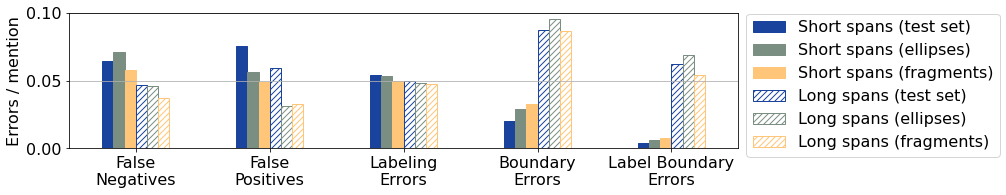

In [35]:
ax = plt.figure(figsize=(12,2.5)).add_subplot(111)

stats[error_cols].T.rename(
    {
        'false_negative' : 'False\nNegatives',
        'false_positive' : 'False\nPositives',
        'labeling_error' : 'Labeling\nErrors',
        'boundary_error' : 'Boundary\nErrors',
        'label_boundary_error' : 'Label Boundary\nErrors',
    }).rename({
        'test_short_full' : 'Short spans (test set)',
        'test_short_ellipsis' : 'Short spans (ellipses)',
        'test_short_fragment' : 'Short spans (fragments)',
        'test_long_full' : 'Long spans (test set)',
        'test_long_ellipsis' : 'Long spans (ellipses)',
        'test_long_fragment' : 'Long spans (fragments)'
    }, axis=1
    ).plot.bar(rot=0, ax=ax
)

ax.grid(axis='y')

c1, c2, c3 = '#19439c', '#7a8e82', '#ffc67a'

bars = ax.patches
hatches = [None] * 15 + ['////'] * 15
colors = ([c1] * 5 + [c2] * 5 + [c3] * 5) * 3

for bar, hatch, color in zip(bars, hatches, colors):
    if not hatch:
        bar.set_color(color)
    else:
        bar.set_color('white')
    bar.set_edgecolor(color)
    bar.set_hatch(hatch)

    
ax.set_ylabel('Errors / mention')
    
plt.legend(bbox_to_anchor=(1.0, 1.05))

plt.savefig('error_analysis.png', dpi=600, bbox_inches="tight")

plt.show()

### Manual inspection

In [57]:
pipe_long('Krebs-Vorsorge / -Früherkennung')

[{'entity_group': 'Diagnostic',
  'score': 0.95874846,
  'word': 'Krebs',
  'start': 0,
  'end': 5},
 {'entity_group': 'Therapeutic',
  'score': 0.7189618,
  'word': 'Vorsorge',
  'start': 6,
  'end': 14},
 {'entity_group': 'Diagnostic',
  'score': 0.9999958,
  'word': 'Früherkennung',
  'start': 18,
  'end': 31}]

In [58]:
pipe_long('HPV31, 33, 45 und 51')

[{'entity_group': 'Diagnosis_or_Pathology',
  'score': 0.99999326,
  'word': 'HPV31, 33, 45 und 51',
  'start': 0,
  'end': 20}]

In [59]:
pipe_long('Vitamin C, E und A1')

[{'entity_group': 'Nutrient_or_Body_Substance',
  'score': 0.99998546,
  'word': 'Vitamin C',
  'start': 0,
  'end': 9},
 {'entity_group': 'Nutrient_or_Body_Substance',
  'score': 0.99999636,
  'word': 'E',
  'start': 11,
  'end': 12},
 {'entity_group': 'Nutrient_or_Body_Substance',
  'score': 0.8202621,
  'word': 'A1',
  'start': 17,
  'end': 19}]

In [60]:
pipe_long('Chemo- und Strahlentherapie')

[{'entity_group': 'Therapeutic',
  'score': 0.9999934,
  'word': 'Chemo',
  'start': 0,
  'end': 5},
 {'entity_group': 'Therapeutic',
  'score': 0.99999523,
  'word': 'Strahlentherapie',
  'start': 11,
  'end': 27}]

In [61]:
pipe_long('BRAF- und MEK-Inhibitor')

[{'entity_group': 'Clinical_Drug',
  'score': 0.99998295,
  'word': 'BRAF',
  'start': 0,
  'end': 4},
 {'entity_group': 'Clinical_Drug',
  'score': 0.99777585,
  'word': 'MEK - Inhibitor',
  'start': 10,
  'end': 23}]

In [62]:
pipe_long('zielgerichtete und Immuntherapien')

[{'entity_group': 'Therapeutic',
  'score': 0.99971545,
  'word': 'zielgerichtete',
  'start': 0,
  'end': 14},
 {'entity_group': 'Therapeutic',
  'score': 0.99998003,
  'word': 'Immuntherapien',
  'start': 19,
  'end': 33}]

In [63]:
pipe_long('HPV-16- und/oder -18-Positivität')

[{'entity_group': 'Diagnosis_or_Pathology',
  'score': 0.9999793,
  'word': 'HPV - 16',
  'start': 0,
  'end': 6},
 {'entity_group': 'Diagnosis_or_Pathology',
  'score': 0.9017949,
  'word': '18 - Positivität',
  'start': 18,
  'end': 32}]

In [64]:
pipe_long('BRCA1/2-Mutation')

[{'entity_group': 'Diagnosis_or_Pathology',
  'score': 0.99999297,
  'word': 'BRCA1',
  'start': 0,
  'end': 5},
 {'entity_group': 'Diagnosis_or_Pathology',
  'score': 0.9999868,
  'word': '2 - Mutation',
  'start': 6,
  'end': 16}]

In [65]:
pipe_long('Zweitlinien- oder Drittliniensystem- bzw. -chemotherapie')

[{'entity_group': 'Therapeutic',
  'score': 0.9999924,
  'word': 'Zweitlinien',
  'start': 0,
  'end': 11},
 {'entity_group': 'Therapeutic',
  'score': 0.99999326,
  'word': 'Drittliniensystem',
  'start': 18,
  'end': 35},
 {'entity_group': 'Therapeutic',
  'score': 0.9999935,
  'word': 'chemotherapie',
  'start': 43,
  'end': 56}]